# Flowers Image Classifier with Deep Learning

This application trains an image classifier to recognize different species of flowers and predict the species of the flower on a picture.

<img src='assets/Flowers.png' width=500px>

This notebook is broken down into multiple steps:

* Loading and preprocessing of the image dataset
* Training of the image classifier on the dataset
* Predicting an image content using the trained classifier

In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import torch
from torch import nn
from torch import optim
from torchvision import datasets, transforms, models
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import os, random

## Data loading

Here `torchvision` is used to load the data ([documentation](http://pytorch.org/docs/0.3.0/torchvision/index.html)). The data should be included alongside this notebook, otherwise you can [download it here](https://s3.amazonaws.com/content.udacity-data.com/nd089/flower_data.tar.gz). The dataset is split into three parts, training, validation, and testing. For the training, we apply transformations such as random scaling, cropping, and flipping. This will help the network generalize leading to better performance. We also make sure the input data is resized to 224x224 pixels as required by the pre-trained networks.

The validation and testing sets are used to measure the model's performance on data it hasn't seen yet.

The pre-trained networks were trained on the ImageNet dataset where each color channel was normalized separately. For all three sets we normalize the means and standard deviations of the images to what the network expects. For the means, it's `[0.485, 0.456, 0.406]` and for the standard deviations `[0.229, 0.224, 0.225]`, calculated from the ImageNet images. These values will shift each color channel to be centered at 0 and range from -1 to 1.
 

In [2]:
data_dir = 'flowers'
train_dir = data_dir + '/train'
valid_dir = data_dir + '/valid'
test_dir = data_dir + '/test'

In [3]:
# Transforms for the training, validation, and testing sets
transform, dataset, dataloader = dict(), dict(), dict()

transform['training'] = transforms.Compose([transforms.RandomRotation(30),
                                       transforms.RandomResizedCrop(224),
                                       transforms.RandomHorizontalFlip(),
                                       transforms.ToTensor(),
                                       transforms.Normalize([0.485, 0.456, 0.406], 
                                                            [0.229, 0.224, 0.225])])

transform['validation']= transforms.Compose([transforms.Resize(255),
                                    transforms.CenterCrop(224),
                                    transforms.ToTensor(),
                                    transforms.Normalize([0.485, 0.456, 0.406], 
                                                            [0.229, 0.224, 0.225])])

transform['testing'] = transforms.Compose([transforms.Resize(255),
                                    transforms.CenterCrop(224),
                                    transforms.ToTensor(),
                                    transforms.Normalize([0.485, 0.456, 0.406], 
                                                            [0.229, 0.224, 0.225])])

# Load the datasets with ImageFolder
dataset['training'] = datasets.ImageFolder(train_dir, transform=transform['training'])
dataset['validation'] = datasets.ImageFolder(valid_dir, transform=transform['validation'])
dataset['testing'] = datasets.ImageFolder(test_dir, transform=transform['testing'])

# Define the dataloaders
dataloader['training'] = torch.utils.data.DataLoader(dataset['training'], batch_size=64, shuffle=True)
dataloader['validation'] = torch.utils.data.DataLoader(dataset['validation'], batch_size=64, shuffle=True)
dataloader['testing'] = torch.utils.data.DataLoader(dataset['testing'], batch_size=64, shuffle=True)

### Label mapping

We load a mapping from category label to category name. We find this in the file `cat_to_name.json`. This JSON file contains a dictionary mapping the integer encoded categories to the actual names of the flowers.

In [4]:
import json

with open('cat_to_name.json', 'r') as f:
    cat_to_name = json.load(f)

# Building and training the classifier

The data is now ready, it's time to build and train the classifier. As usual, we use one of the pretrained models from `torchvision.models` to get the image features. We build and train a new feed-forward classifier using those features.

Things the following cell does:

* Load a [pre-trained network](http://pytorch.org/docs/master/torchvision/models.html)
* Define a new, untrained feed-forward network as a classifier, using ReLU activations and dropout
* Train the classifier layers using backpropagation using the pre-trained network to get the features
* Track the loss and accuracy on the validation set to determine the best hyperparameters

When training we make sure we are updating only the weights of the feed-forward network.

In [5]:
# Use cuda if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load the model
model = models.densenet121(pretrained=True)

# Learning rate
learning_rate = 0.003

# Freeze model parameters
for param in model.parameters():
    param.requires_grad = False
    
# Define classifier architecture
model.classifier = nn.Sequential(nn.Linear(1024, 500),
                                 nn.ReLU(),
                                 nn.Dropout(0.4),
                                 nn.Linear(500, 102),
                                 nn.LogSoftmax(dim=1))

criterion = nn.NLLLoss()

# Only train the classifier parameters, feature parameters are frozen
optimizer = optim.Adam(model.classifier.parameters(), lr=learning_rate)

model.to(device)

DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu

In [6]:
epochs = 2
steps = 0
running_loss = 0
print_every = 10

train_losses, valid_losses = [], []
for epoch in range(epochs):
    for inputs, labels in dataloader['training']:
        steps += 1
        
        # Move the inputs and labels to device
        inputs, labels = inputs.to(device), labels.to(device)
                
        optimizer.zero_grad()
        
        logps = model.forward(inputs)
        loss = criterion(logps, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        
        if steps % print_every == 0:
            test_loss = 0
            accuracy = 0
            model.eval()
            with torch.no_grad():
                for inputs, labels in dataloader['validation']:
                    inputs, labels = inputs.to(device), labels.to(device)
                    
                    logps = model.forward(inputs)
                    loss = criterion(logps, labels)
                    
                    test_loss += loss.item()
                    
                    ps = torch.exp(logps)
                    top_p, top_class = ps.topk(1, dim=1)
                    
                    equals = top_class == labels.view(*top_class.shape)
                    accuracy += torch.mean(equals.type(torch.FloatTensor)).item()
            
            train_losses.append(running_loss/print_every)
            valid_losses.append(test_loss/len(dataloader['validation']))
            
            print(f"Epoch: {epoch+1}/{epochs}",
                 f"Train loss: {running_loss/print_every:.3f}.. ",
                 f"Test Loss: {test_loss/len(dataloader['validation']):.3f}.. ",
                 f"Test Accuracy: {accuracy/len(dataloader['validation'])*100:.3f}% ")

            running_loss = 0
            model.train()
            
            

Epoch: 1/2 Train loss: 4.666..  Test Loss: 4.309..  Test Accuracy: 6.885% 
Epoch: 1/2 Train loss: 4.178..  Test Loss: 3.904..  Test Accuracy: 16.014% 
Epoch: 1/2 Train loss: 3.918..  Test Loss: 3.364..  Test Accuracy: 25.178% 
Epoch: 1/2 Train loss: 3.462..  Test Loss: 2.855..  Test Accuracy: 36.663% 
Epoch: 1/2 Train loss: 3.104..  Test Loss: 2.440..  Test Accuracy: 47.308% 
Epoch: 1/2 Train loss: 2.631..  Test Loss: 2.006..  Test Accuracy: 50.995% 
Epoch: 1/2 Train loss: 2.380..  Test Loss: 1.725..  Test Accuracy: 61.481% 
Epoch: 1/2 Train loss: 2.320..  Test Loss: 1.520..  Test Accuracy: 66.067% 
Epoch: 1/2 Train loss: 2.014..  Test Loss: 1.367..  Test Accuracy: 66.188% 
Epoch: 1/2 Train loss: 1.877..  Test Loss: 1.229..  Test Accuracy: 70.255% 
Epoch: 2/2 Train loss: 1.901..  Test Loss: 1.148..  Test Accuracy: 73.207% 
Epoch: 2/2 Train loss: 1.680..  Test Loss: 1.066..  Test Accuracy: 73.995% 
Epoch: 2/2 Train loss: 1.686..  Test Loss: 0.969..  Test Accuracy: 77.856% 
Epoch: 2/2 Tr

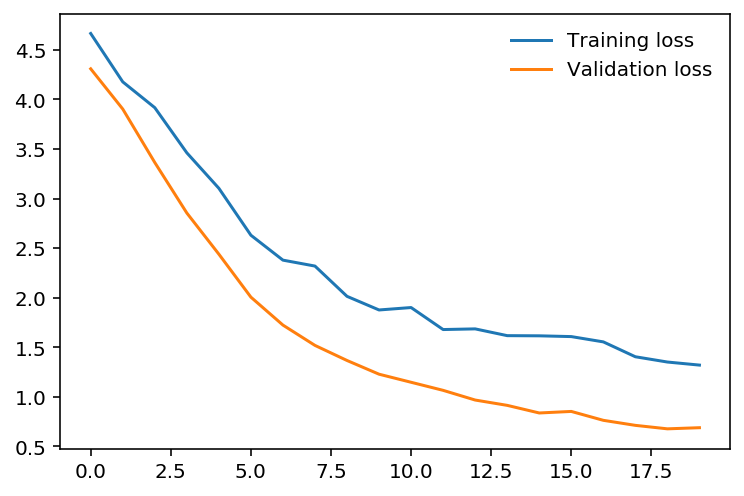

In [7]:
plt.plot(train_losses, label='Training loss')
plt.plot(valid_losses, label='Validation loss')
plt.legend(frameon=False)

## Testing the network

In [8]:
# Validation on the test set
test_loss = 0
accuracy = 0
model.eval()
with torch.no_grad():
    for inputs, labels in dataloader['testing']:
        inputs, labels = inputs.to(device), labels.to(device)

        logps = model.forward(inputs)
        loss = criterion(logps, labels)

        test_loss += loss.item()

        ps = torch.exp(logps)
        top_p, top_class = ps.topk(1, dim=1)

        equals = top_class == labels.view(*top_class.shape)
        accuracy += torch.mean(equals.type(torch.FloatTensor)).item()

print(f"Validation Loss: {test_loss/len(dataloader['testing']):.3f}.. ",
     f"Validation Accuracy: {accuracy/len(dataloader['testing'])*100:.3f}% ")

Validation Loss: 0.719..  Validation Accuracy: 82.028% 


## Save the checkpoint

Now that the network is trained, we save the model so we can load it later for making predictions.

In [9]:
# Save the checkpoint
checkpoint = {'model_state_dict': model.state_dict(),
             'optimizer_state_dict': optimizer.state_dict(),
             'classifier': model.classifier,
             'criterion': criterion,
             'arch': 'densenet121',
             'learning_rate': learning_rate,
             'class_to_idx': dataset['training'].class_to_idx}

torch.save(checkpoint, 'checkpoint.pth')

/Volumes/Data/ge0ra/opt/anaconda3/envs/classifier/lib/python3.7/site-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type Sequential. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/Volumes/Data/ge0ra/opt/anaconda3/envs/classifier/lib/python3.7/site-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type Linear. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/Volumes/Data/ge0ra/opt/anaconda3/envs/classifier/lib/python3.7/site-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type ReLU. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/Volumes/Data/ge0ra/opt/anaconda3/envs/classifier/lib/python3.7/site-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for co

## Loading the checkpoint

The following function loads a checkpoint and rebuild the model.

In [10]:
# Load a checkpoint and rebuild the model
def load_checkpoint(filepath, gpu):
    
    if gpu:
        checkpoint = torch.load(filepath)
    else:
        checkpoint = torch.load(filepath, map_location="cpu")
    
    # Load the pretrained model
    model = getattr(models, checkpoint['arch'])(pretrained=True)
    
    model.classifier = checkpoint['classifier']
    model.load_state_dict(checkpoint['model_state_dict'])
    model.class_to_idx = checkpoint['class_to_idx']
    
    # Freeze the parameters so we dont backpropagate through them
    for param in model.parameters():
        param.requires_grad = False
        
    for param in model.classifier.parameters():
        param.requires_grad = True
    
    optimizer = optim.Adam(model.classifier.parameters(), lr=checkpoint['learning_rate'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    
    return model, optimizer
    
model, optimizer = load_checkpoint('checkpoint.pth', True)

# Inference for classification

## Image Preprocessing

We use `PIL` to load the image ([documentation](https://pillow.readthedocs.io/en/latest/reference/Image.html)). This function process the images in the same manner used for training. 

First, it resizes the images where the shortest side is 256 pixels, keeping the aspect ratio. Then it crops out the center 224x224 portion of the image.

Color channels of images are encoded as integers 0-255, but the model expected floats 0-1. We convert the values. 

The network expects the images to be normalized in a specific way. For the means, it's `[0.485, 0.456, 0.406]` and for the standard deviations `[0.229, 0.224, 0.225]`.

And finally, PyTorch expects the color channel to be the first dimension but it's the third dimension in the PIL image and Numpy array. So, we reorder dimensions using [`ndarray.transpose`](https://docs.scipy.org/doc/numpy-1.13.0/reference/generated/numpy.ndarray.transpose.html).

In [11]:
# Process a PIL image for use in a PyTorch model
def process_image(image_path):
    ''' Scales, crops, and normalizes a PIL image for a PyTorch model,
        returns an Numpy array
    '''
    img = Image.open(image_path)
    
    # Keep aspect ratio and set shortest side to 256
    width, height = 256, 256
    if img.size[0] > img.size [1]:
        width = img.size[0]/img.size[1]*height
    else:
        height = img.size[1]/img.size[0]*width
    
    img.thumbnail((width, height))
    
    # Center crop
    left = (img.width-224)/2
    right = left + 224
    top = (img.height-224)/2
    bottom = top + 224
    img = img.crop((left, top, right, bottom))
    
    # Color channels from 0-255 to 0-1 (expected by the model)
    np_img = np.array(img)/255
    
    # Normalize the image
    means, std = np.array([0.485, 0.456, 0.406]), np.array([0.229, 0.224, 0.225])
    np_img = (np_img - means) / std
    
    # Reorder dimension for PyTorch
    np_img = np_img.transpose((2, 0, 1))
    
    # Alternatively:
    #preprocess = transforms.Compose([transforms.Resize(256),
    #                                 transforms.CenterCrop(224),
    #                                 transforms.ToTensor(),
    #                                 transforms.Normalize([0.485, 0.456, 0.406],
    #                                                      [0.229, 0.224, 0.225])])
    #preprocess(img)
    
    return np_img

In [12]:
def imshow(image, ax=None, title=None):
    """Imshow for Tensor."""
    if ax is None:
        fig, ax = plt.subplots()
    
    # PyTorch tensors assume the color channel is the first dimension
    # but matplotlib assumes is the third dimension
    image = image.transpose((1, 2, 0))
    
    # Undo preprocessing
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    image = std * image + mean
    
    # Image needs to be clipped between 0 and 1 or it looks like noise when displayed
    image = np.clip(image, 0, 1)
    
    ax.imshow(image)
    
    return ax

## Class Prediction

In [13]:
# Predict the class from an image file
def predict(image_path, model, topk=5):
    ''' Predict the class (or classes) of an image using a trained deep learning model.
    '''    
    
    # Set device
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    model.to(device)
    
    model.eval()
    with torch.no_grad():
        
        img = process_image(image_path)
        img = torch.from_numpy(np.array([img])).to(device).float()
        
        logps = model(img)

        ps = torch.exp(logps)
        top_p, top_class = ps.topk(topk, dim=1)
        
        # Convert tensor to list
        top_class = top_class.tolist()[0]
        top_p = top_p.tolist()[0]
        
        # Reverse index / values
        idx_to_class = {i: c for c, i in model.class_to_idx.items()}
        
        for idx, c in enumerate(top_class):
            top_class[idx] = str(cat_to_name[idx_to_class[c]]).capitalize()
        
        return top_p, top_class

## Sanity Checking

We check our work, to make sure it makes sense. It should look like this:

<img src='assets/inference_example.png' width=300px>


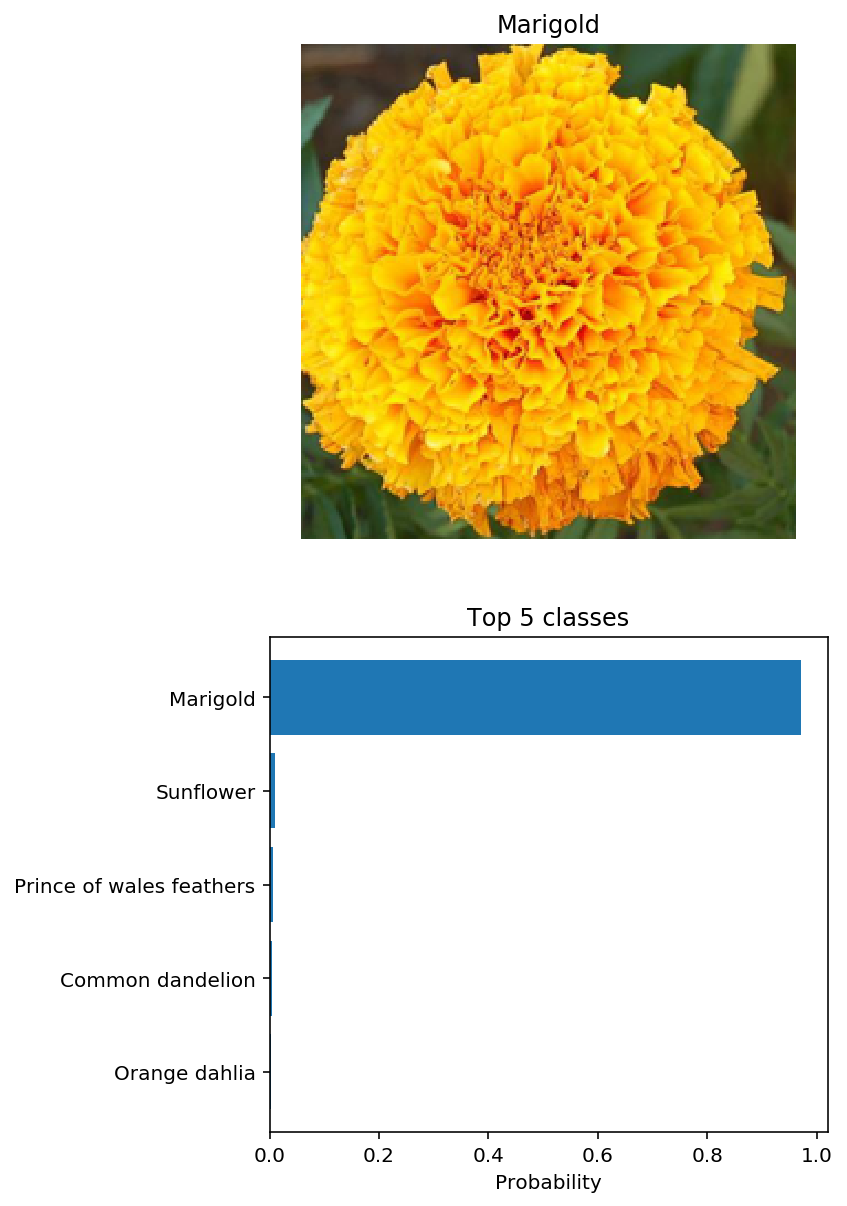

In [14]:
# Display a random image along with the top 5 classes
dir_number = random.choice(os.listdir(test_dir))
filename = random.choice(os.listdir(test_dir + '/' + dir_number + '/'))

image_path = test_dir + '/' + dir_number + '/' + filename
probs, classes = predict(image_path, model)

title = str(classes[0]).capitalize()
img = process_image(image_path)

fig = plt.figure(figsize = [5, 10])

# First plot
ax1 = fig.add_subplot(2, 1, 1)
ax1.axis('off')
ax1.title.set_text(title)
imshow(img, ax1)

# Second plot
ax2 = fig.add_subplot(2, 1, 2)
y_pos = np.arange(len(classes))

ax2.set_yticks(y_pos)
ax2.set_yticklabels(classes)
ax2.invert_yaxis()
ax2.set_xlabel('Probability')
ax2.set_title('Top 5 classes')
ax2.barh(y_pos, probs, align='center');

